# **Install PyTorch and Dependencies**

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5f2fc000 @  0x7fa0387f22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1
  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
4.0.0


# **Beggining of Project**

**Import libraries**

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch import optim
import helper
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

**Check for CUDA**

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Load the data**

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
classes = cat_to_name
print(classes)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [0]:
# helper function to un-normalize and display an image
def preview(img):
  
    img = img.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)  # convert from Tensor image

In [0]:
data_dir = './flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'

In [0]:
# Define your transforms for the training and validation sets
data_transforms = transforms.Compose([
                                        transforms.Resize(224),
                                        transforms.CenterCrop(244),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform= data_transforms)
test_data  = datasets.ImageFolder(valid_dir, transform= data_transforms)


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 30
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader =  torch.utils.data.DataLoader(test_data,  batch_size=batch_size, num_workers=num_workers)



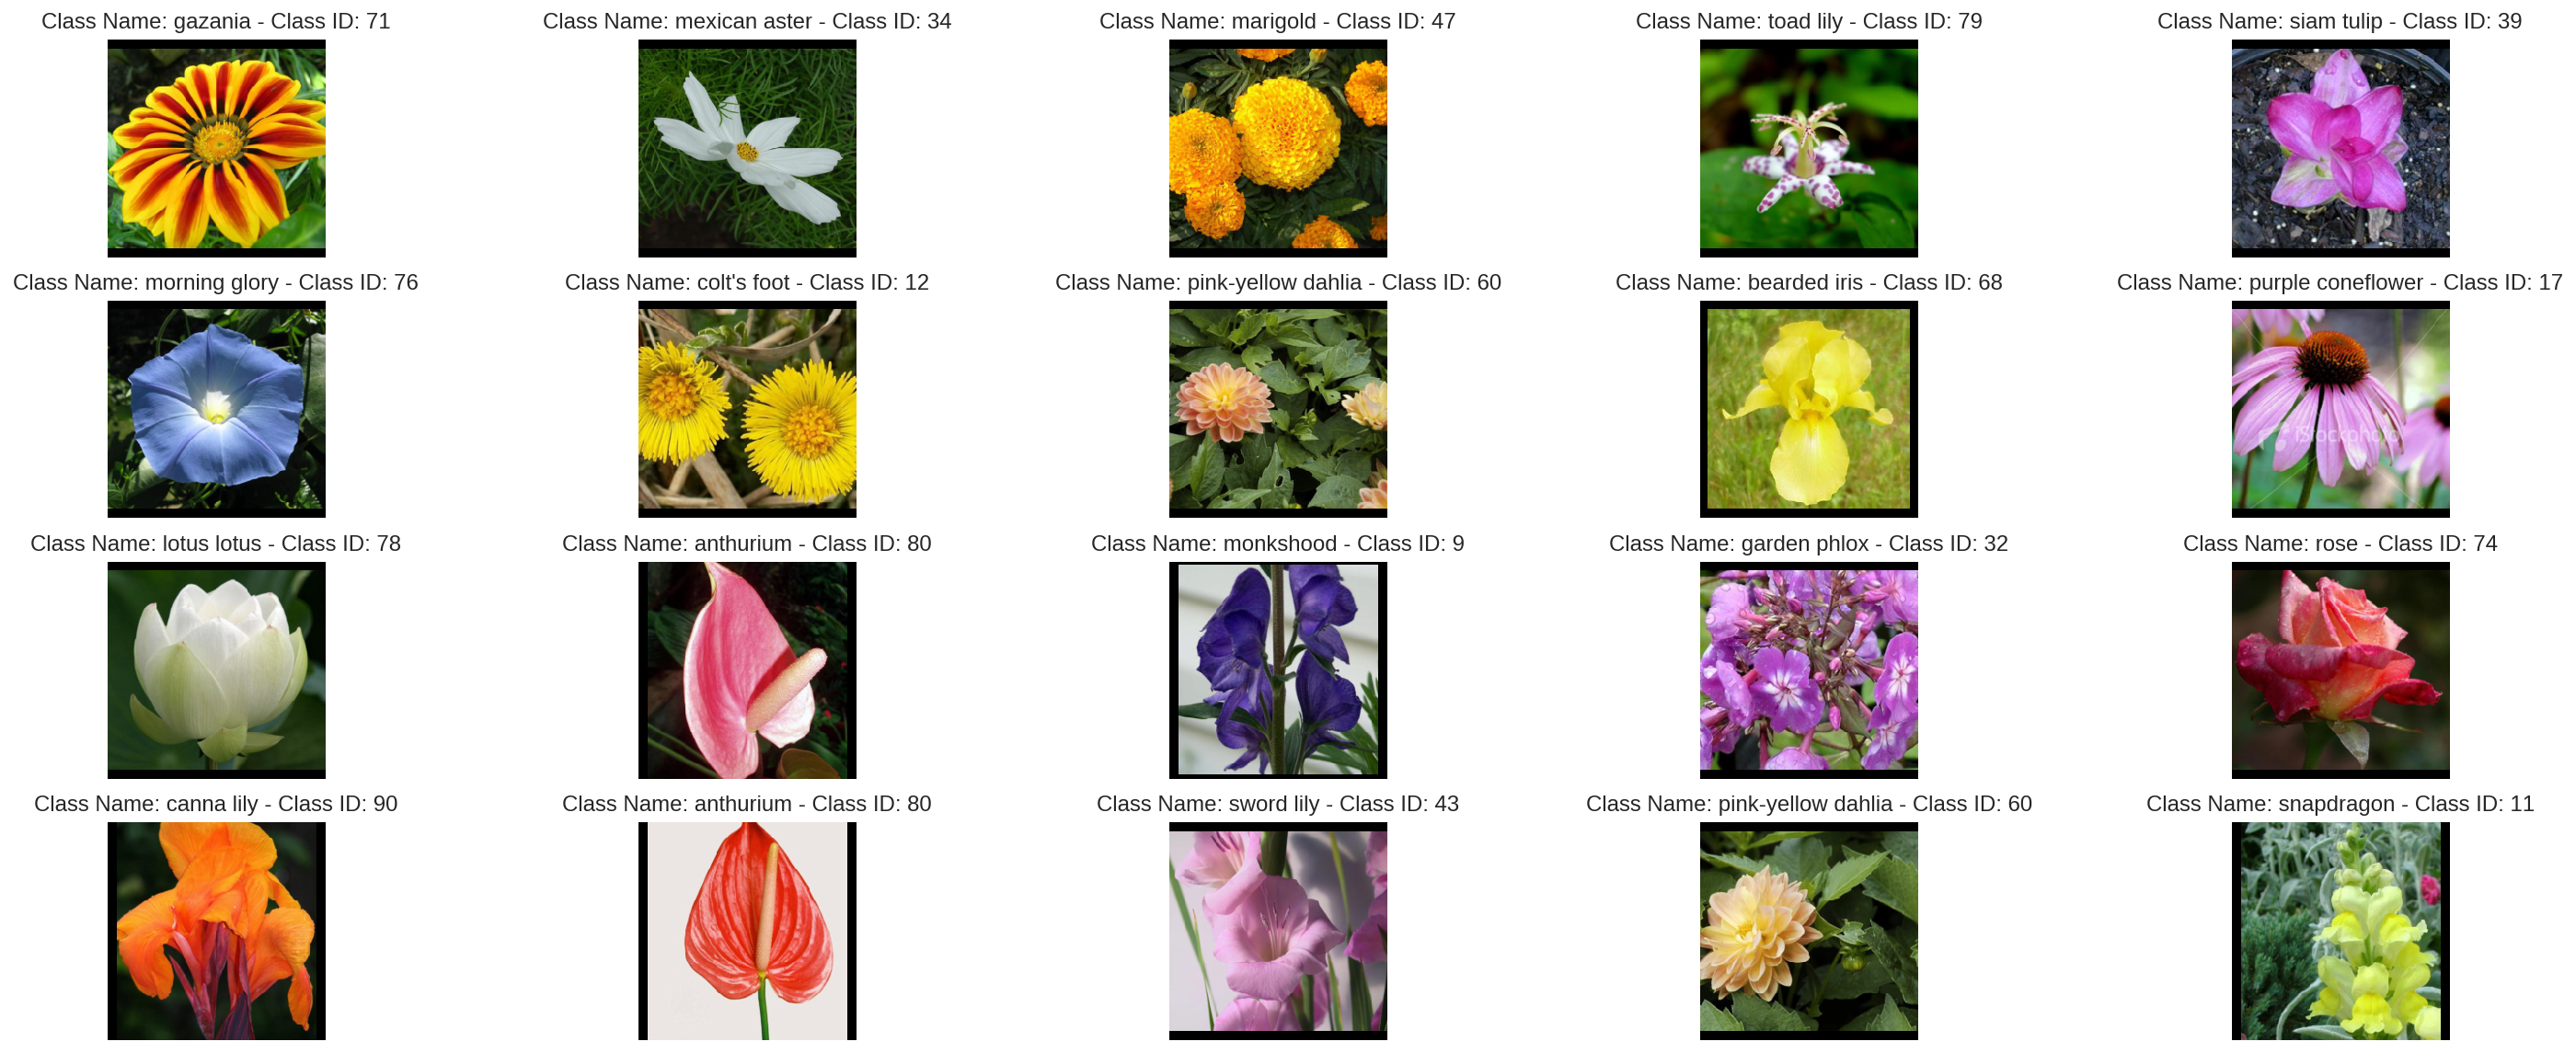

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display


labels_map = train_data.class_to_idx
inv_map = {v: k for k, v in labels_map.items()}

L = []
for x in range(len(labels)):
  L.append(inv_map[labels[x].item()])
  
labels = L


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    #fig.tight_layout(pad=1.08,)
    
    ax.set_title("Class Name: " + classes[labels[idx]] + " - " + "Class ID: " + str(labels[idx]))
    preview(images[idx])




# **Download and Use The VGG16 Model**



In [0]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 86133098.15it/s]


In [0]:
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features) 

4096
1000


In [0]:
n_inputs = model.classifier[6].in_features
n_inputs
print(model.classifier[6].out_features) 

1000


In [0]:
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False

In [0]:
n_inputs = model.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs
print(model.classifier[6].out_features)
print(model)

102
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Co

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.002)

# **Training**

In [0]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss


# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for data, target in train_loader:
      
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
          
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    
    for data, target in valid_loader:
      
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_vgg16.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.333402 	Validation Loss: 0.697872
Validation loss decreased (inf --> 0.697872).  Saving model ...
Epoch: 2 	Training Loss: 2.453960 	Validation Loss: 0.473020
Validation loss decreased (0.697872 --> 0.473020).  Saving model ...
Epoch: 3 	Training Loss: 1.708212 	Validation Loss: 0.314477
Validation loss decreased (0.473020 --> 0.314477).  Saving model ...
Epoch: 4 	Training Loss: 1.242330 	Validation Loss: 0.233458
Validation loss decreased (0.314477 --> 0.233458).  Saving model ...
Epoch: 5 	Training Loss: 0.976918 	Validation Loss: 0.184382
Validation loss decreased (0.233458 --> 0.184382).  Saving model ...
Epoch: 6 	Training Loss: 0.776514 	Validation Loss: 0.153862
Validation loss decreased (0.184382 --> 0.153862).  Saving model ...
Epoch: 7 	Training Loss: 0.669059 	Validation Loss: 0.134611
Validation loss decreased (0.153862 --> 0.134611).  Saving model ...
Epoch: 8 	Training Loss: 0.565627 	Validation Loss: 0.120193
Validation loss decreased (0.13461

# **Load saved model**

In [0]:
model.load_state_dict(torch.load('model_vgg16.pt'))

# **Test the Trained model**

In [0]:
classes

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

model.eval()
#count = 0

# iterate over test data
for data, target in test_loader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        #print(correct[i].item())
        class_correct[label] += correct[i].item()
        class_total[label] += 1

In [0]:
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[str(i+1)], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[str(i+1)]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000001

Test Accuracy of pink primrose: 87% ( 7/ 8)
Test Accuracy of hard-leaved pocket orchid: 75% ( 3/ 4)
Test Accuracy of canterbury bells: 83% ( 5/ 6)
Test Accuracy of sweet pea: 100% ( 5/ 5)
Test Accuracy of english marigold: 100% ( 6/ 6)
Test Accuracy of tiger lily: 80% ( 8/10)
Test Accuracy of moon orchid: 100% ( 5/ 5)
Test Accuracy of bird of paradise: 80% ( 4/ 5)
Test Accuracy of monkshood: 100% ( 1/ 1)
Test Accuracy of globe thistle: 100% ( 7/ 7)
Test Accuracy of snapdragon: 100% ( 2/ 2)
Test Accuracy of colt's foot: 93% (15/16)
Test Accuracy of king protea: 63% ( 7/11)
Test Accuracy of spear thistle: 25% ( 1/ 4)
Test Accuracy of yellow iris: 100% ( 6/ 6)
Test Accuracy of globe-flower: 85% ( 6/ 7)
Test Accuracy of purple coneflower: 100% ( 4/ 4)
Test Accuracy of peruvian lily: 100% ( 8/ 8)
Test Accuracy of balloon flower: 100% (12/12)
Test Accuracy of giant white arum lily: 100% ( 5/ 5)
Test Accuracy of fire lily: 100% ( 2/ 2)
Test Accuracy of pincushion flower: 

In [0]:
train_on_gpu

True

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)



In [0]:
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())



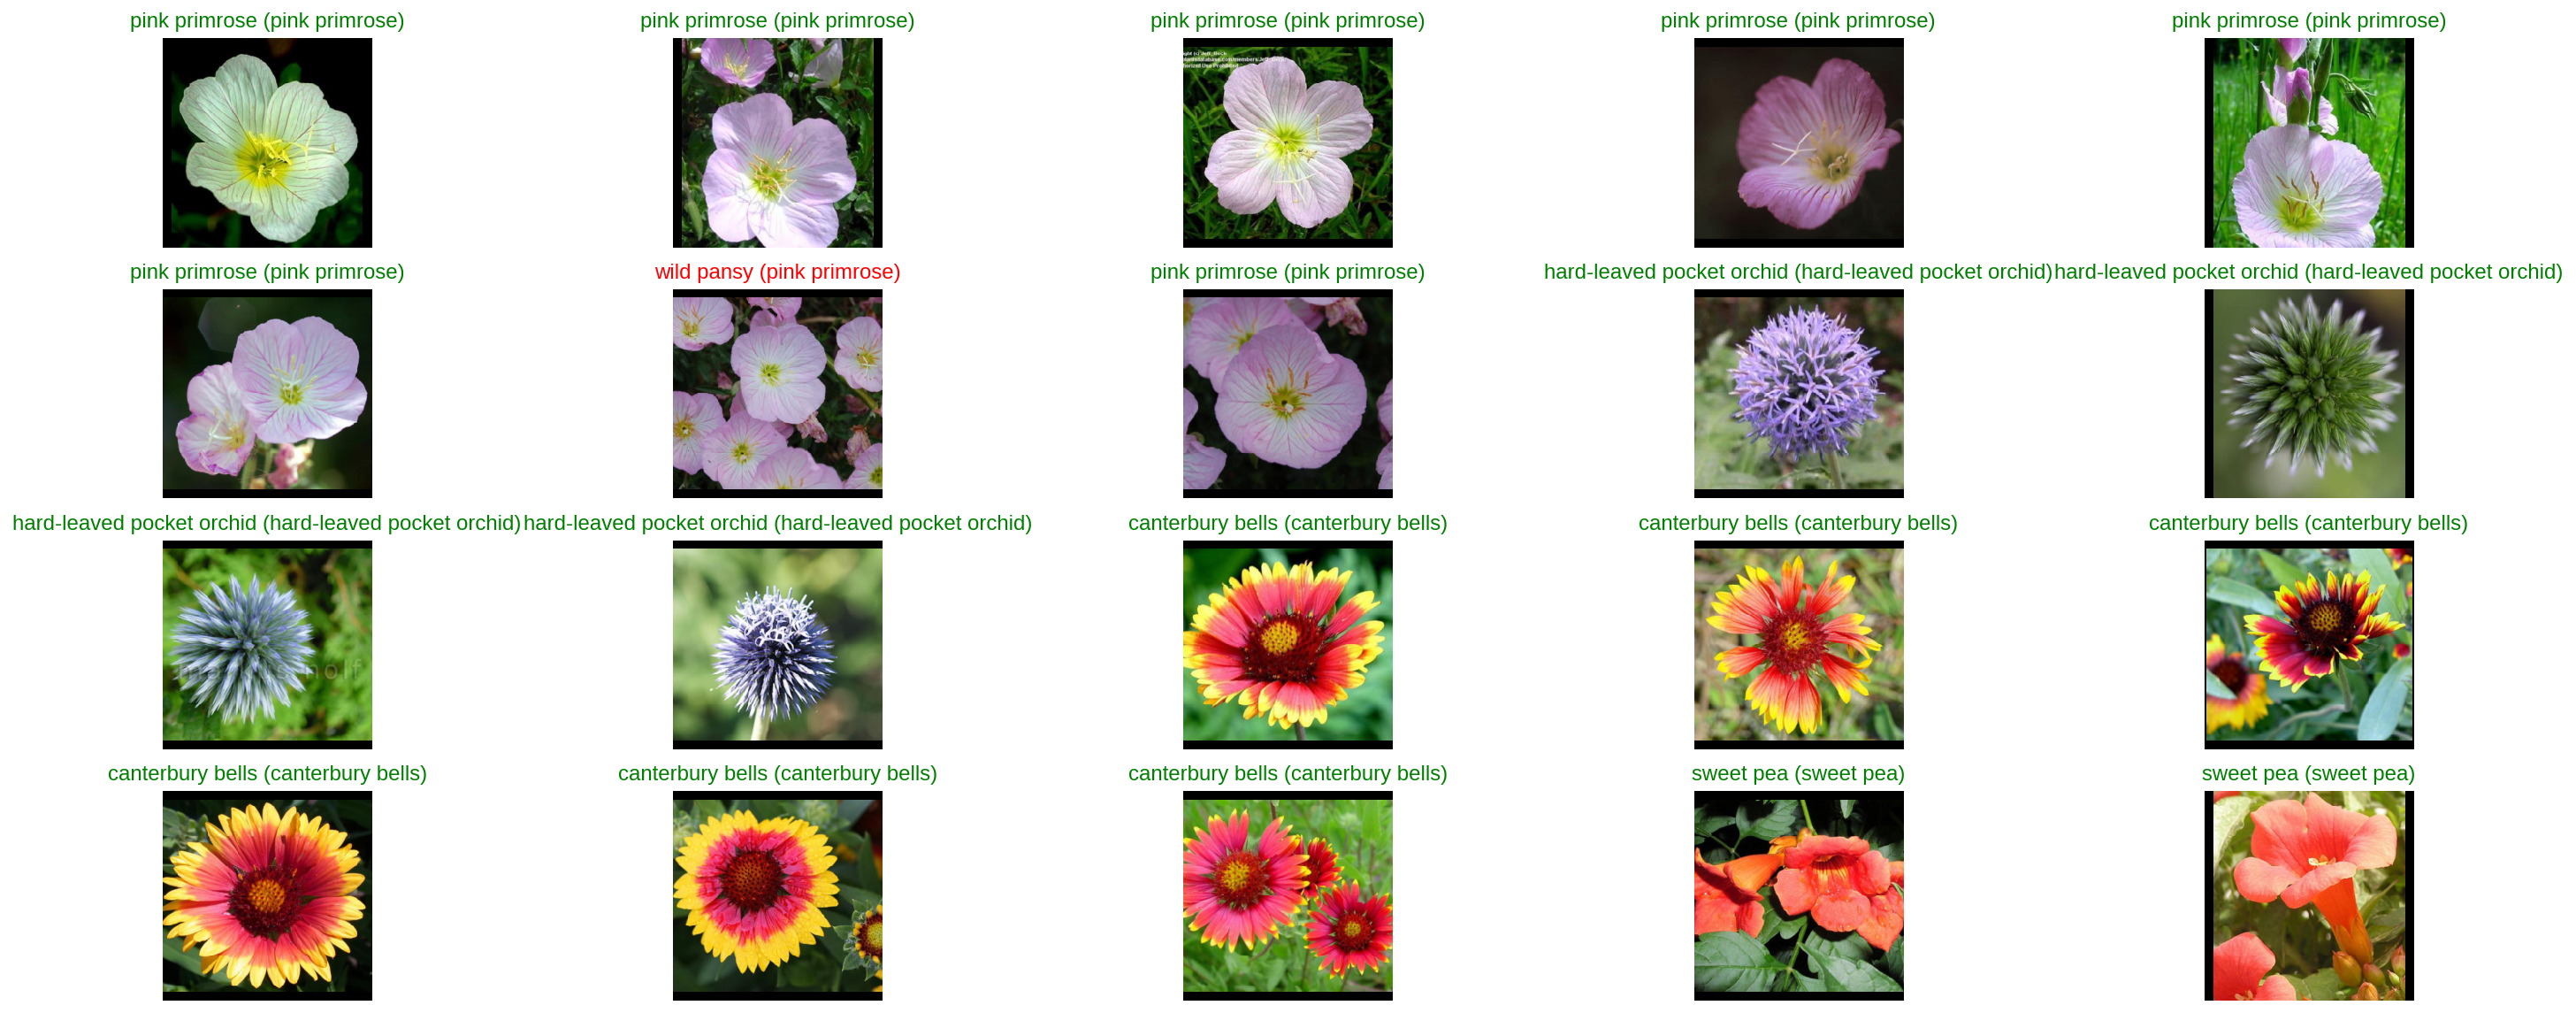

In [0]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    preview(images[idx].cpu().numpy())
    ax.set_title("{} ({})".format(classes[str(preds[idx]+1)], classes[str(labels[idx].item()+1)]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
torch.save(model.state_dict(), 'model_vgg16.pt')

In [0]:
model_save_name = 'model_vgg16.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)